In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import astropy.units as u
import astropy.constants as const
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

In [3]:
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator

color_map = {
    'cyan': '#66c2a5',
    'orange': '#ff7f00',
    'blue': '#8da0cb',
    'purple': '#7570b3',
    'pink': '#fccde5',
    'green': '#33a02c',
    'yellow': '#ffd92f',
    'brown': '#e5c494',
    'magenta': '#f1598a',
    'grey': '0.3'
}

In [4]:
import glob
import os
import sys
sys.path.append('../tools/')

from fits2ascii import wavelength_convert_air_vacuum
from visual import rcparams_format

rcparams_format(mpl.rcParams)

In [234]:
from astropy.visualization import ZScaleInterval
from regions import CircleSkyRegion, RectangleSkyRegion, LineSkyRegion


In [425]:
sci_files = sorted(glob.glob("../../Spectra/2023-04-26_LRIS/pypeit/keck_lris_red_mark4_B/Science/spec2d*SN2022joj*fits"))
raw_files = sorted(glob.glob("../../Spectra/2023-04-26_LRIS/r/r230427_0008[6-8].fits"))
coadd_file = "../../Spectra/2023-04-26_LRIS/pypeit/keck_lris_red_mark4_B/Coadding/Science_coadd/spec2d_r230427-r230427-SN2022joj.fits"
spec = np.loadtxt("./data/ZTF22aajijjf_20230426_LRIS.ascii")

In [93]:
spec_bino_pypeit = np.loadtxt("../../Spectra/MMT/SN2022joj_host/pypeit/mmt_binospec_A/SN2022joj_20230314_Binospec.ascii")
hdul_bino_auto = fits.open("../../Spectra/MMT/SN2022joj_host/auto_reduced/SN2022joj_host_B.fits")

In [238]:
def plot_box_spec(wave, flux):
    flux_plot = np.repeat(flux, 2)
    wv_plot = wave.copy()
    wv_plot[:-1] += np.diff(wave) / 2
    wv_plot = np.append(
        wave[0] - (wave[1] - wave[0]) / 2,
        np.append(np.repeat(wv_plot[0:-1], 2),
                  wave[-1] + (wave[-1] - wave[-2]) / 2))

    return wv_plot, flux_plot

In [462]:
from scipy.interpolate import griddata

sci_imgs = []
sub_imgs = []
wcs_sols = []
for k in range(3):
    with fits.open(sci_files[k]) as hdu:
        sciimg = hdu[1].data
        skymodel = hdu[3].data
        bpmmask = hdu[9].data
        waveimg = wavelength_convert_air_vacuum(hdu[8].data)
        wcs = WCS(fits.open(raw_files[k])[0].header)

        sci_imgs.append(sciimg.T)
        sub_imgs.append(np.where(bpmmask == 0, sciimg - skymodel, -1).T)
        wcs_sols.append(wcs)

sci_img_stack = sci_imgs[0]

/Users/chang/Desktop/SN2022joj/spectroscopy/../tools/fits2ascii.py:15: RuntimeWarning: divide by zero encountered in divide
  sigma = 1.0/lambda1*1e8
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-BEG to 60061.559478 from DATE-BEG.
Set MJD-END to 60061.573367 from DATE-END'. [astropy.wcs.wcs]
Set MJD-BEG to 60061.574131 from DATE-BEG.
Set MJD-END to 60061.588020 from DATE-END'. [astropy.wcs.wcs]
Set MJD-BEG to 60061.588781 from DATE-BEG.
Set MJD-END to 60061.602670 from DATE-END'. [astropy.wcs.wcs]


In [463]:
with fits.open(coadd_file) as hdu:
    sciimg = hdu[1].data
    skymodel = hdu[3].data
    bpmmask = hdu[9].data
    waveimg = wavelength_convert_air_vacuum(hdu[8].data)
sub_img_stack = np.where(bpmmask == 0, sciimg - skymodel, -1).T

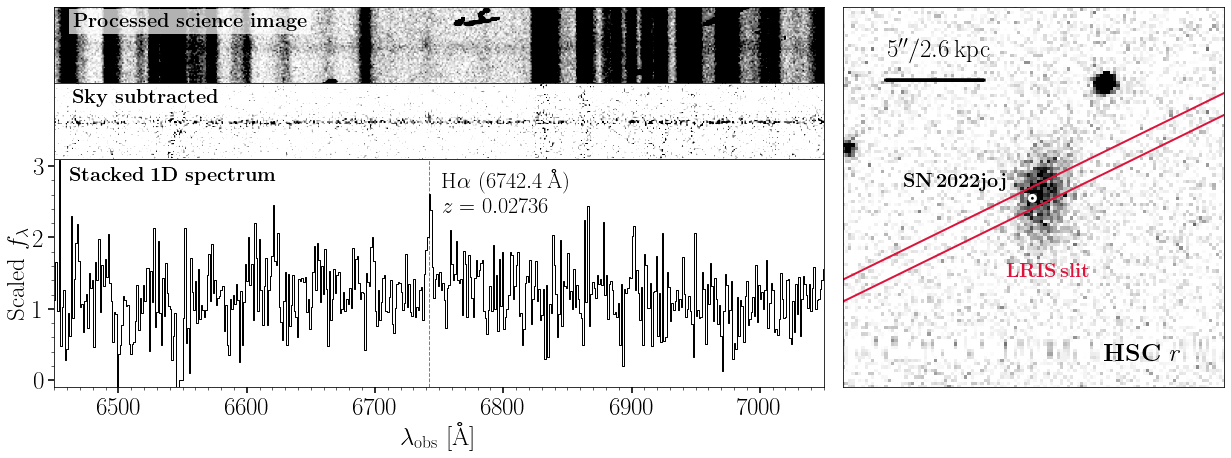

In [92]:
fig = plt.figure(figsize=(21, 7))
widths = [3, 1.5]
heights = [1, 1, 3]
gs = fig.add_gridspec(ncols=2, nrows=3, width_ratios=widths, height_ratios=heights)
gs.update(wspace=0.03, hspace=0)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0])

ax = [ax0, ax1]

left, right = 900, 1400
wv_left, wv_right = 6450, 7050

x1 = waveimg[left, 240:245].mean()
x2 = waveimg[right, 240:245].mean()

A = (right - left) / (x2 - x1)
B = right - A * x2



ax[0].imshow(
    ZScaleInterval()(sci_img_stack),
    cmap="Greys",
    vmin=.25,
    vmax=.4,
    aspect="auto",
)
ax[1].imshow(
    ZScaleInterval()(sub_img_stack),
    cmap="Greys",
    vmin=0.55,
    vmax=0.65,
    aspect="auto",
)

ax[0].text(
    A * wv_left + B + 12,
    942,
    r"$\mathbf{Processed\ science\ image}$",
    fontsize=20,
    bbox={"alpha": 0.7, "color": "w", "lw": 0},
)
ax[1].text(
    A * wv_left + B + 12,
    257,
    r"$\mathbf{Sky\ subtracted}$",
    fontsize=20,
    bbox={"alpha": 0.9, "color": "w", "lw": 0},
)

ax[0].set_ylim(905, 955)
ax[1].set_ylim(220, 270)

for a in ax:
    a.set_xticks([])
    a.set_yticks([])
    a.set_xlim(A * np.array([wv_left, wv_right]) + B)

ax_1dspec = fig.add_subplot(gs[2, 0])
wv, fl = plot_box_spec(spec[:, 0], spec[:, 1])
ax_1dspec.plot(wv, fl * 5.6, color="k", lw=1)
ax_1dspec.text(wv_left + 12, 2.8, r"$\mathbf{Stacked\ 1D\ spectrum}$", fontsize=20)

ax_1dspec.set_xlim(wv_left, wv_right)
ax_1dspec.set_ylim(-0.1, 3.1)

ax_1dspec.xaxis.set_major_locator(MultipleLocator(100))
ax_1dspec.xaxis.set_minor_locator(MultipleLocator(10))
ax_1dspec.yaxis.set_major_locator(MultipleLocator(1))
ax_1dspec.yaxis.set_minor_locator(MultipleLocator(0.2))

ax_1dspec.set_ylabel(r"$\mathrm{Scaled}\ f_\lambda$")
ax_1dspec.set_xlabel(r"$\lambda_\mathrm{obs}\ [\mathrm{\r{A}}]$")

z = 0.02736
ax_1dspec.axvline(6562.8 * (1 + z), color="0.5", lw=1, linestyle="--", zorder=-100)
ax_1dspec.text(
    6562.8 * (1 + z) + 10,
    2.7,
    r"$\mathrm{H}\alpha\ $"
    + r"$({:.1f}\,".format(6562.8 * (1 + z))
    + r"\mathrm{\r{A}})$",
    fontsize=22.5,
)
ax_1dspec.text(6562.8 * (1 + z) + 10, 2.35, rf"$z={z}$", fontsize=22.5)

# image and slit
ax_image = fig.add_subplot(gs[:, 1])
image = "./host/cutout-HSC-R-10102-pdr3_wide-230517-211640.fits"
dat = fits.getdata(image, 1)
ax_image.imshow(ZScaleInterval()(dat), vmin=0.35, cmap="Greys", origin="lower")

hdr = fits.getheader(image, 1)
wcs = WCS(hdr)

SN = SkyCoord(220.4169551, 3.0067475, unit=u.degree)
SN_region = CircleSkyRegion(SN, 0.15 * u.arcsec)
SN_pixel_region = SN_region.to_pixel(wcs)
SN_pixel_region.plot(ax=ax_image, color="w", lw=3)

host = SkyCoord(220.4168333, 3.0068139, unit=u.degree)
slit_region = RectangleSkyRegion(
    center=host,
    width=1 * u.arcsec,
    height=100 * u.arcsec,
    angle=116.1010 * u.deg,
)
slit_pixel_region = slit_region.to_pixel(wcs)
slit_pixel_region.plot(ax=ax_image, color="crimson", lw=2)

trim = 50
ax_image.set_xlim(trim, dat.shape[0] - trim)
ax_image.set_ylim(trim, dat.shape[0] - trim)

legend = RectangleSkyRegion(
    center=SkyCoord(220.4168333 + 0.0015, 3.0068139 + 0.0016, unit=u.degree),
    width=0.00001 * u.arcsec,
    height=5 * u.arcsec,
    angle=90 * u.deg,
)
legend_pixel = legend.to_pixel(wcs)
legend_pixel.plot(ax=ax_image, color="k", lw=3)

D_A = 108.71e3  # kpc
L_proj = D_A * 5 / 3600 / 180 * np.pi
ax_image.text(
    79,
    152,
    r"$5''/" + r"{:.1f}".format(L_proj) + r"\,\mathrm{kpc}$",
    ha="center",
    va="center",
    bbox={"alpha": 0.2, "lw": 0, "color": "w"},
)
ax_image.text(
    84,
    112,
    r"$\mathbf{SN\,2022joj}$",
    color="k",
    fontsize=20,
    ha="center",
    va="center",
)
ax_image.text(
    112,
    85,
    r"$\mathbf{LRIS\, slit}$",
    color="crimson",
    fontsize=20,
    ha="center",
    va="center",
)
ax_image.text(
    140,
    60,
    r"$\mathbf{HSC\ \it{r}}$",
    ha="center",
    va="center",
    bbox={"alpha": 0.2, "lw": 0, "color": "w"},
)

ax_image.set_xticks([])
ax_image.set_yticks([])

plt.savefig("../paper/figures/host_spec.pdf", bbox_inches="tight")

LRIS
Bino


(-1.0, 4.5)

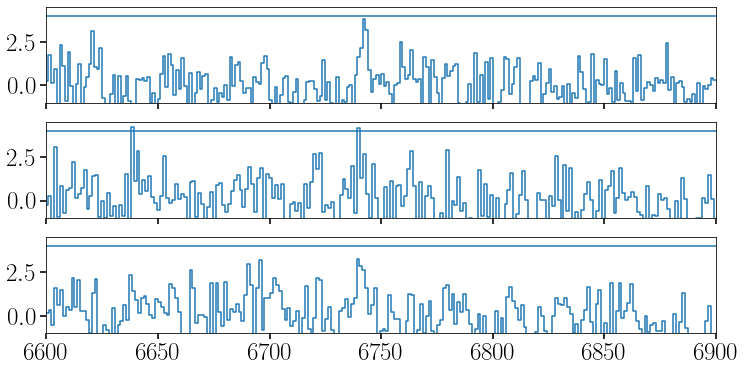

In [102]:
# snr
fig, ax = plt.subplots(3, 1, figsize=(12, 6), sharex=True, sharey=True)

for k in range(3):
    if k == 0:
        wv, fl, fl_unc = spec[:, 0], spec[:, 1], spec[:, 2]
        print('LRIS')
    elif k == 1:
        wv, fl, fl_unc = spec_bino_pypeit[:, 0], spec_bino_pypeit[:, 1], spec_bino_pypeit[:, 2]
        print('Bino')
    elif k == 2:
        hdr, dat = hdul_bino_auto[0].header, hdul_bino_auto[0].data
        wv = hdr["CRVAL1"] + np.arange(len(dat[0])) * hdr["CDELT1"]
        fl, fl_unc = dat[0], dat[1]
    
    wv_idx = (wv > 6600) & (wv < 6900)
    line_idx = (wv > 6720) & (wv < 6740)
    base = np.mean(fl[wv_idx & ~line_idx])
    wv_box, fl_box = plot_box_spec(wv, (fl-base)/fl_unc)
    ax[k].plot(wv_box, fl_box)
    ax[k].axhline(4)
plt.xlim(6600, 6900)
plt.ylim(-1, 4.5)

In [133]:
def SNR(spec, wv_line, wv_width, N=1000):
    wv, fl, fl_unc = spec
    line_idx = (wv >= wv_line - wv_width / 2) & (wv <= wv_line + wv_width / 2)
    n_pixel_line = line_idx.sum()
    fl_line = np.sum(fl[line_idx] * fl_unc[line_idx] ** -2) / np.sum(
        fl_unc[line_idx] ** -2
    )

    iter = 0
    fl_bkg = np.empty(N)
    while iter < N:
        idx = np.random.random_integers(low=0, high=len(wv) - n_pixel_line - 1)
        if ((wv[idx] >= wv[line_idx][0]) and (wv[idx] <= wv[line_idx][-1])) or (
            (wv[idx + n_pixel_line] >= wv[line_idx][0])
            and (wv[idx + n_pixel_line] <= wv[line_idx][-1])
        ):
            continue
        fl_bkg[iter] = np.sum(
            fl[idx : idx + n_pixel_line] * fl_unc[idx : idx + n_pixel_line] ** -2
        ) / np.sum(fl_unc[idx : idx + n_pixel_line] ** -2)
        iter += 1
    SNR = (fl_line - fl_bkg.mean()) / np.std(fl_unc)
    return SNR


SNR(spec.T, wv_line=6742.4, wv_width=1)

/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_3238/4189903787.py:12: DeprecationWarning: This function is deprecated. Please call randint(0, 4962 + 1) instead
  idx = np.random.random_integers(low=0, high=len(wv) - n_pixel_line - 1)


4.087867455333577

(160.0, 110.0)

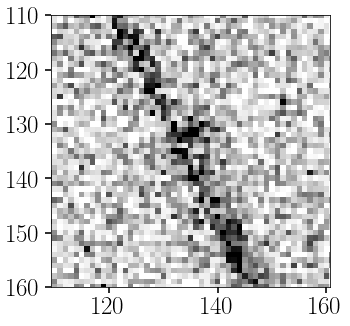

In [562]:
from scipy import ndimage


fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
size = 100
ax.imshow(
    ndimage.rotate(
        ZScaleInterval()(
            sub_img_stack.T[1150 - size : 1150 + size, 245 - size : 245 + size]
        ),
        116.1010 - 90,
    ),
    cmap="Greys",
    vmin=0.4,
    vmax=0.8,
    aspect="auto",
)
ax.axis("equal")
ax.set_xlim(110, 160)
ax.set_ylim(160, 110)

In [531]:
sub_img_stack.T.shape

(4120, 898)